# Import supporting package

In [1]:
import xarray as xr
import numpy as np

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import NewFitModel
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:51119' processes=6 threads=60, memory=55.88 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_3",
}


In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Repetition_scan" + "/"
folderPath = img_dir + SequenceName + '2023/' + get_date()

# An example for one experimental run

## Load the data

In [5]:
shotNum = "0065"
filePath = folderPath + "/" + shotNum + "/*.h5"
filePath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/12/0065/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0] # range(len(groupList))
}

dataSet = dataSetDict["camera_1"]
dataSet = swap_xy(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

<xarray.Dataset>
Dimensions:       (sin_mod_freq: 37, y: 1200, x: 1920)
Coordinates:
  * sin_mod_freq  (sin_mod_freq) float64 65.0 66.0 67.0 ... 99.0 100.0 101.0
Dimensions without coordinates: y, x
Data variables:
    atoms         (sin_mod_freq, y, x) uint16 dask.array<chunksize=(29, 1200, 1920), meta=np.ndarray>
    background    (sin_mod_freq, y, x) uint16 dask.array<chunksize=(29, 1200, 1920), meta=np.ndarray>
    dark          (sin_mod_freq, y, x) uint16 dask.array<chunksize=(29, 1200, 1920), meta=np.ndarray>
    shotNum       (sin_mod_freq) int64 dask.array<chunksize=(37,), meta=np.ndarray>
    OD            (sin_mod_freq, y, x) float64 dask.array<chunksize=(29, 1200, 1920), meta=np.ndarray>
Attributes: (12/109)
    TOF_free:                          0.01
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    0.001
    blink_on_time:                     0.001
    ...                                ...
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    sin_mod_freq:                      [ 65.  66.  67.  68.  69.  70.  71.  7...
    scanAxis:                          ['sin_mod_freq']
    scanAxisLength:                    [37.]

## Calculate an plot OD images

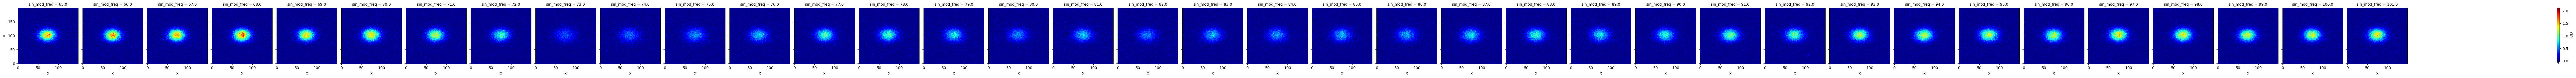

In [6]:
imageAnalyser.center = (959, 280)
imageAnalyser.span = (150, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

## Do a 2D two-peak gaussian fit to the OD images

### Do the fit

In [7]:
fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)

params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params).load()

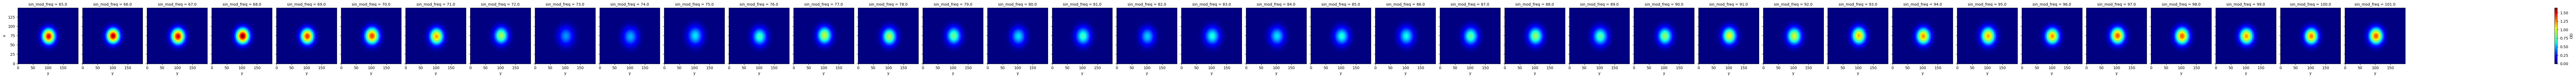

In [8]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(150), y=np.arange(200), dask="parallelized").load()

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

### Get the result of the fit

In [9]:
fitAnalyser.get_fit_value(fitResult)

<xarray.Dataset>
Dimensions:       (sin_mod_freq: 37)
Coordinates:
  * sin_mod_freq  (sin_mod_freq) float64 65.0 66.0 67.0 ... 99.0 100.0 101.0
Data variables:
    amplitude     (sin_mod_freq) float64 1.808e+03 1.824e+03 ... 1.838e+03
    centerx       (sin_mod_freq) float64 73.1 74.3 72.99 ... 73.44 73.32 73.94
    centery       (sin_mod_freq) float64 102.0 101.4 102.1 ... 101.7 102.4 102.6
    sigmax        (sin_mod_freq) float64 13.57 13.13 13.86 ... 14.41 14.1 14.47
    sigmay        (sin_mod_freq) float64 14.06 13.93 14.49 ... 14.98 14.53 14.95
    fwhmx         (sin_mod_freq) float64 31.95 30.93 32.63 ... 33.94 33.21 34.08
    fwhmy         (sin_mod_freq) float64 33.12 32.8 34.11 ... 35.29 34.22 35.21
    height        (sin_mod_freq) float64 14.88 15.66 15.11 ... 12.13 12.67 13.34

In [10]:
fitAnalyser.get_fit_std(fitResult)

<xarray.Dataset>
Dimensions:       (sin_mod_freq: 37)
Coordinates:
  * sin_mod_freq  (sin_mod_freq) float64 65.0 66.0 67.0 ... 99.0 100.0 101.0
Data variables:
    amplitude     (sin_mod_freq) float64 4.983 4.902 5.145 ... 5.149 4.996 5.165
    centerx       (sin_mod_freq) float64 0.0374 0.0353 ... 0.04263 0.04066
    centery       (sin_mod_freq) float64 0.03876 0.03744 ... 0.04393 0.04201
    sigmax        (sin_mod_freq) float64 0.0374 0.0353 ... 0.04263 0.04066
    sigmay        (sin_mod_freq) float64 0.03876 0.03744 ... 0.04393 0.04201
    fwhmx         (sin_mod_freq) float64 0.08806 0.08313 ... 0.1004 0.09574
    fwhmy         (sin_mod_freq) float64 0.09127 0.08816 ... 0.1034 0.09892
    height        (sin_mod_freq) float64 0.04101 0.04209 ... 0.0383 0.03749

In [11]:
fitAnalyser.get_fit_full_result(fitResult)

<xarray.Dataset>
Dimensions:       (sin_mod_freq: 37)
Coordinates:
  * sin_mod_freq  (sin_mod_freq) float64 65.0 66.0 67.0 ... 99.0 100.0 101.0
Data variables:
    amplitude     (sin_mod_freq) object 1808+/-5 1824+/-5 ... 1653+/-5 1838+/-5
    centerx       (sin_mod_freq) object 73.10+/-0.04 ... 73.94+/-0.04
    centery       (sin_mod_freq) object 102.02+/-0.04 ... 102.56+/-0.04
    sigmax        (sin_mod_freq) object 13.57+/-0.04 ... 14.47+/-0.04
    sigmay        (sin_mod_freq) object 14.06+/-0.04 ... 14.95+/-0.04
    fwhmx         (sin_mod_freq) object 31.95+/-0.09 ... 34.08+/-0.10
    fwhmy         (sin_mod_freq) object 33.12+/-0.09 ... 35.21+/-0.10
    height        (sin_mod_freq) object 14.88+/-0.04 ... 13.34+/-0.04

## Get the Ncount

### Calculate the mean and standard deviation

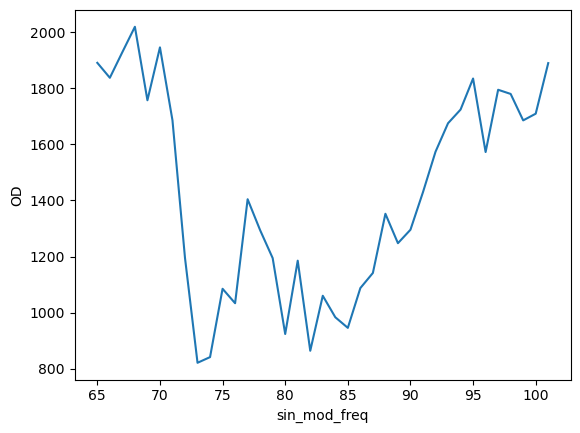

In [12]:
Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)

Ncount.load()
Ncount_mean = calculate_mean(Ncount)
Ncount_std = calculate_std(Ncount)
Ncount_mean.plot.errorbar(yerr=Ncount_std)
plt.show()

###  Do a 1D fit

In [13]:
def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(1e-10, np.sqrt(2*np.pi)*sigma)))
            * np.exp(-(1.0*x-center)**2 / max(1e-10, (2*sigma**2))))

fitModel = NewFitModel(gaussian)

fitModel.make_params()

Parameters([('amplitude', <Parameter 'amplitude', value=1.0, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=0.0, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=1.0, bounds=[-inf:inf]>)])

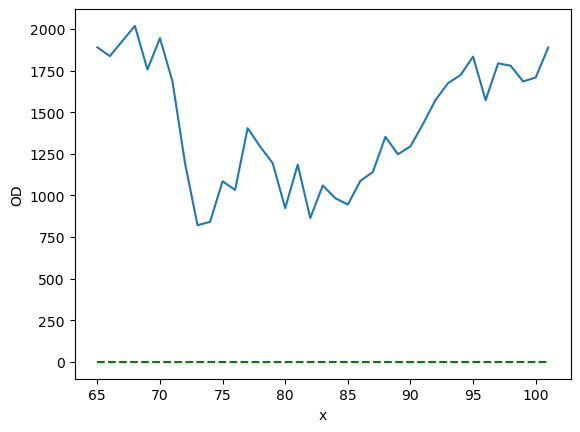

In [14]:
fitAnalyser = FitAnalyser(fitModel, fitDim=1)

params = fitAnalyser.guess(Ncount_mean, x="sin_mod_freq", dask="parallelized")
fitResult = fitAnalyser.fit(Ncount_mean, params, x="sin_mod_freq").load()

plot_x = np.linspace(Ncount_mean["sin_mod_freq"].min(), Ncount_mean["sin_mod_freq"].max(), 100)

fitCurve = fitAnalyser.eval(fitResult, x=plot_x, dask="parallelized").load()

fig = plt.figure()
ax = fig.gca()

Ncount_mean.plot.errorbar(ax=ax, yerr=Ncount_std)
fitCurve.plot.errorbar(ax=ax, fmt='--g')

plt.show()

ValueError: Line plots are for 1- or 2-dimensional DataArrays. Passed DataArray has 3 dimensions

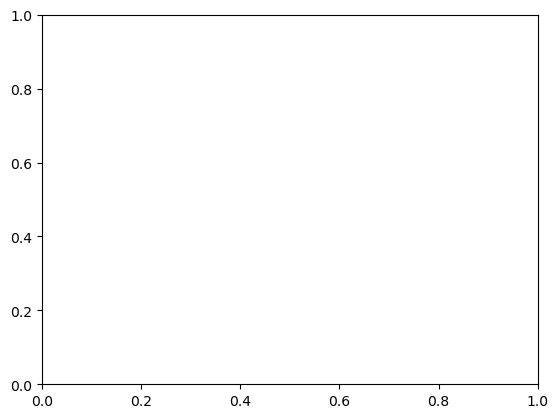

In [15]:
fitCurve = fitCurve.rename(dict(x='final_amp'))
plot_dataSe = xr.combine_nested([Ncount_mean, fitCurve], ['plot'])

fig = plt.figure()
ax = fig.gca()
plot_dataSe.sel(plot=[0, 1]).plot.errorbar(ax=ax, hue='plot', x='final_amp', fmt=['ob', '-g'])
plt.show()


# Select data and remove bad shot

In [ ]:
plot_dataSe.where( (Ncount_mean[scanAxis[0]]<2e-4) & (Ncount_mean[scanAxis[0]]>1e-4) )